<div style="border: 2px solid #0066cc; padding: 15px; border-radius: 10px; background-color: #f8f9fa; text-align: center; color: #333; font-weight: bold;">

# **Retail Inventory Management System - LangGraph Waterfall Implementation**

</div>

## 📊 **Overview**
This project demonstrates a **multi-agent workflow** for building a **Retail Inventory Management System** using the **Waterfall methodology**. Leveraging **LangGraph's agent framework**, each specialized AI agent contributes to a distinct phase, from **requirements gathering** to **final deployment**.

# Setting Up the LangGraph Waterfall Project

Import the required libraries:

In [20]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any, Literal, Union, Optional
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
import os
import re
import time
import json
from fpdf import FPDF
from dotenv import load_dotenv

# OpenAI Integration Setup

- Loading API credentials securely using `dotenv.load_dotenv()`.
- Configuring `llm_config` to use the `"gpt-4o-mini"` model with an API key from environment variables.

In [21]:
# Load environment variables
_ = load_dotenv()

# Set up OpenAI client
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("The OPENAI_API_KEY environment variable is not set.")

# Initialize the model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=api_key)

### **Below is the complete set of AI agent prompts for the LangGraph-based Retail Inventory Management System following the Waterfall methodology.**

In [22]:
# === System Prompts for LangGraph Agile Scrum Agents ===

CUSTOMER_PROMPT = """You are a Customer Proxy agent acting as a mediator between the retail stakeholder and the AI Scrum team.

Your role is to clearly relay inventory management expectations, goals, and user pain points to the Product Owner.

Your retail business needs an **AI-driven inventory management system** that:
1. Tracks inventory levels in real-time.
2. Predicts stock shortages and suggests reorder points.
3. Automates reordering processes based on demand forecasting.
4. Supports multiple warehouse locations.
5. Generates comprehensive reports on stock movement.

At the end of every sprint, you will review and provide feedback for potential changes or approvals.
"""

PRODUCT_OWNER_PROMPT = """You are a Product Owner in an Agile Scrum team.

### Responsibilities:
- Translate the **Customer Proxy's** high-level business goals into user stories and backlog items.
- Prioritize and maintain the product backlog.
- Collaborate with all Scrum roles to define sprint goals.
- Communicate customer feedback to the team.
- Ensure all sprint deliverables meet customer expectations.

### Deliverables:
- Product backlog with user stories.
- Sprint plan (sprint goals, estimates, priority).
- Feedback response and change plan.
"""

SCRUM_MASTER_PROMPT = """You are the Scrum Master, a facilitator of Agile ceremonies and responsible for removing blockers.

### Responsibilities:
- Facilitate daily standups, sprint planning, sprint reviews, and retrospectives.
- Ensure Scrum principles are followed.
- Help the team improve velocity and remove impediments.
- Promote collaboration and communication among all agents.

### Deliverables:
- Summary of Scrum ceremonies.
- Identified blockers and mitigation plans.
"""

BUSINESS_ANALYST_PROMPT = """You are a Business Analyst collaborating with the Product Owner to refine user stories.

### Responsibilities:
- Break down product backlog items into detailed requirements.
- Include acceptance criteria, user personas, and edge cases.
- Clarify ambiguous user needs.

### Deliverables:
- Detailed functional and non-functional requirements.
- Workload estimates and productivity planning.
"""

ARCHITECT_PROMPT = """You are a System Architect designing scalable solutions.

### Responsibilities:
- Convert user stories into architecture components.
- Produce diagrams (components, APIs, DB schemas).
- Identify risks and technical constraints.

### Deliverables:
- Architectural blueprint.
- Design metrics and rework plan if needed.
"""

DEVELOPER_PROMPT = """You are a Developer responsible for delivering features as per the sprint backlog.

### Responsibilities:
- Write modular, testable code.
- Estimate lines of code (SLOC), productivity, and sprint duration.
- Collaborate with QA, UI/UX, and PO.

### Deliverables:
- Feature implementation.
- Sprint burndown progress report.
"""

UI_UX_DESIGNER_PROMPT = """You are a UI/UX Designer focused on user-centric interface design.

### Responsibilities:
- Create wireframes and high-fidelity designs for prioritized user stories.
- Incorporate accessibility and responsiveness.
- Estimate design effort and timeline.

### Deliverables:
- Screens per sprint.
- Design feedback incorporated from reviews.
"""

QA_ENGINEER_PROMPT = """You are a QA Engineer responsible for validating sprint deliverables.

### Responsibilities:
- Develop test cases based on user stories.
- Execute functional, regression, and integration tests.
- Report bugs with severity levels.

### Deliverables:
- Test coverage metrics.
- QA sign-off or defect backlog.
"""

DEVOPS_ENGINEER_PROMPT = """You are a DevOps Engineer handling CI/CD pipelines and environment readiness.

### Responsibilities:
- Build CI/CD pipelines for testing and deployment.
- Define infrastructure as code (IaC).
- Monitor build and deployment success.

### Deliverables:
- Deployment plan per sprint.
- Productivity and environment uptime metrics.
"""

SECURITY_ENGINEER_PROMPT = """You are a Security Engineer safeguarding the system from vulnerabilities.

### Responsibilities:
- Conduct sprint-based security audits.
- Perform threat modeling and code scanning.
- Recommend risk mitigation.

### Deliverables:
- Security report per sprint.
- Checklist of patches or concerns.
"""

TECHNICAL_WRITER_PROMPT = """You are a Technical Writer responsible for documenting sprint deliverables.

### Responsibilities:
- Write user guides, API docs, release notes.
- Collaborate with developers and testers for accuracy.
- Ensure documentation is clear and version-controlled.

### Deliverables:
- Updated product documentation.
- Summary of sprint releases.
"""


### State definition

In [23]:
class ScrumState(TypedDict):
    customer_req: str
    customer_prompt: Optional[str]
    product_backlog: str
    sprint_backlog: str
    user_stories_doc: str
    design_notes: str
    dev_tasks: List[str]
    test_cases: List[str]
    documentation_notes: str
    sprint_report: str
    current_phase: str
    phase_outputs: Dict[str, str]
    conversation_history: List[Dict[str, str]]
    metrics: Dict[str, Any]
    analysis_summary: str
    human_feedback: str
    rework_needed: bool
    rework_phase: Optional[str]
    feedback_loop_count: int
    completion_status: Literal["in_progress", "completed"]

In [24]:
### State definition for Agile approach
class ScrumState(TypedDict):
    customer_req: str
    customer_prompt: Optional[str]
    product_backlog: str
    sprint_backlog: str
    user_stories_doc: str
    design_notes: str
    dev_tasks: List[str]
    test_cases: List[str]
    documentation_notes: str
    sprint_report: str
    current_phase: str
    phase_outputs: Dict[str, str]
    conversation_history: List[Dict[str, str]]
    metrics: Dict[str, Any]
    analysis_summary: str
    human_feedback: str
    rework_needed: bool
    rework_phase: Optional[str]
    feedback_loop_count: int
    completion_status: Literal["in_progress", "completed"]

# === Utilities ===
def print_agent_response(agent_name, response):
    print("\n" + "=" * 80)
    print(f"🤖 {agent_name} RESPONSE:")
    print("-" * 80)
    print(response)
    print("=" * 80)

# Node functions for Agile implementation
def get_customer_requirements(state: ScrumState):
    """Get initial customer requirements from user input"""
    print("\n" + "=" * 80)
    print("🧑‍💼 CUSTOMER REQUIREMENTS PHASE")
    print("=" * 80)
    print("\nPlease enter your specific requirements for the Inventory Management System:")
    customer_input = input("Please enter your specific requirements for the Inventory Management System for Retailer:")
    
    # Use the customer input to generate a more detailed requirements document
    if customer_input.strip():
        messages = [
            SystemMessage(content=CUSTOMER_PROMPT),
            HumanMessage(content=f"Based on the following input, elaborate on the requirements for the Inventory Management System:\n\n{customer_input}")
        ]
    else:
        customer_input = "I need an inventory management system that can track stock levels in real-time, predict when we'll run out of items, and automatically place orders when stock is low."
        print(f"\nUsing default requirements: '{customer_input}'")
        messages = [
            SystemMessage(content=CUSTOMER_PROMPT),
            HumanMessage(content=f"Based on the following input, elaborate on the requirements for the Inventory Management System:\n\n{customer_input}")
        ]
    
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("CUSTOMER PROXY", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Human_Customer",
        "content": customer_input
    })
    conversation.append({
        "role": "Customer_Proxy",
        "content": response.content
    })
    
    return {
        "customer_req": response.content,
        "customer_prompt": customer_input,
        "current_phase": "requirements_gathering",
        "conversation_history": conversation,
        "phase_outputs": {"Customer_Proxy": response.content},
        "rework_needed": False,
        "feedback_loop_count": 0,
        "completion_status": "in_progress"
    }

def product_backlog_node(state: ScrumState):
    """Product Owner creates the product backlog"""
    print("\n" + "=" * 80)
    print("🧑‍💼 PRODUCT BACKLOG CREATION PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=PRODUCT_OWNER_PROMPT),
        HumanMessage(content=f"Based on the following customer requirements, create a prioritized product backlog with user stories for the Inventory Management System:\n\n{state['customer_req']}")
    ]
    
    # Add any feedback to the prompt if we're in a rework loop
    if state.get("rework_needed") and state.get("human_feedback"):
        messages.append(HumanMessage(content=f"Please revise your product backlog based on this feedback:\n\n{state['human_feedback']}"))
    
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("PRODUCT OWNER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Product_Owner",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Product_Owner"] = response.content
    
    return {
        "product_backlog": response.content,
        "current_phase": "product_backlog_creation",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def get_stakeholder_feedback(state: ScrumState):
    """Get feedback from stakeholders on the product backlog"""
    print("\n" + "=" * 80)
    print("🧑‍💼 STAKEHOLDER FEEDBACK REQUIRED")
    print("=" * 80)
    
    print("\nThe Product Owner has created the following product backlog:")
    print("-" * 50)
    print(state["product_backlog"])
    print("-" * 50)
    
    print("\nWhat do you think about this product backlog?")
    print("1. Approve and continue to sprint planning")
    print("2. Request changes (provide feedback)")
    print("3. View customer requirements")
    
    choice = input("\nEnter your choice (1-3): ")
    
    if choice == "3":
        print("\n==== ORIGINAL CUSTOMER REQUIREMENTS ====")
        print(state["customer_req"])
        print("-" * 50)
        return get_stakeholder_feedback(state)
    
    if choice == "2":
        print("\nPlease provide your feedback for the product owner:")
        feedback = input("> ")
        
        # Store feedback in conversation history
        conversation = state.get("conversation_history", [])
        conversation.append({
            "role": "Human_Stakeholder",
            "content": feedback
        })
        
        return {
            "human_feedback": feedback,
            "rework_needed": True,
            "rework_phase": "product_backlog_creation",
            "feedback_loop_count": state.get("feedback_loop_count", 0) + 1,
            "conversation_history": conversation
        }
    
    # Default to option 1 (approve) for any other input
    print("\nProduct backlog approved. Moving to sprint planning phase...")
    return {
        "rework_needed": False,
        "human_feedback": "Product backlog approved",
        "current_phase": "product_backlog_approved"
    }

def sprint_planning_node(state: ScrumState):
    """Scrum Master facilitates sprint planning"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SPRINT PLANNING PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=SCRUM_MASTER_PROMPT),
        HumanMessage(content=f"""Facilitate a sprint planning session based on the following product backlog. 
        Create a sprint backlog with prioritized items and effort estimates (story points).
        
        Product Backlog:
        {state['product_backlog']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SCRUM MASTER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Scrum_Master",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Scrum_Master"] = response.content
    
    return {
        "sprint_backlog": response.content,
        "current_phase": "sprint_planning",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def user_stories_node(state: ScrumState):
    """Business Analyst refines user stories"""
    print("\n" + "=" * 80)
    print("🧑‍💼 USER STORIES REFINEMENT PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=BUSINESS_ANALYST_PROMPT),
        HumanMessage(content=f"""Based on the following sprint backlog, refine the user stories with detailed acceptance criteria.
        
        Sprint Backlog:
        {state['sprint_backlog']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("BUSINESS ANALYST", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Business_Analyst",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Business_Analyst"] = response.content
    
    return {
        "user_stories_doc": response.content,
        "current_phase": "user_stories_refinement",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def architecture_design_node(state: ScrumState):
    """Architect defines the technical design"""
    print("\n" + "=" * 80)
    print("🧑‍💼 ARCHITECTURE DESIGN PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=ARCHITECT_PROMPT),
        HumanMessage(content=f"""Create an architectural design based on the following user stories.
        
        User Stories:
        {state['user_stories_doc']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SYSTEM ARCHITECT", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "System_Architect",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["System_Architect"] = response.content
    
    return {
        "design_notes": response.content,
        "current_phase": "architecture_design",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def ui_design_node(state: ScrumState):
    """UI/UX Designer creates the interface design"""
    print("\n" + "=" * 80)
    print("🧑‍💼 UI/UX DESIGN PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=UI_UX_DESIGNER_PROMPT),
        HumanMessage(content=f"""Create wireframes and interface designs based on the following user stories and architectural design.
        
        User Stories:
        {state['user_stories_doc']}
        
        Architecture Design:
        {state['design_notes']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("UI/UX DESIGNER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "UI_UX_Designer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["UI_UX_Designer"] = response.content
    
    # Add to design notes
    design_notes = state.get("design_notes", "") + "\n\n## UI/UX Design\n" + response.content
    
    return {
        "design_notes": design_notes,
        "current_phase": "ui_ux_design",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def development_node(state: ScrumState):
    """Developer implements the features"""
    print("\n" + "=" * 80)
    print("🧑‍💼 DEVELOPMENT PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=DEVELOPER_PROMPT),
        HumanMessage(content=f"""Implement the features based on the following user stories and designs.
        
        User Stories:
        {state['user_stories_doc']}
        
        Designs:
        {state['design_notes']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("DEVELOPER", response.content)
    
    # Extract code sections from the response
    code_sections = re.findall(r'```(?:\w+)?\s*([\s\S]*?)```', response.content)
    dev_tasks = [section.strip() for section in code_sections if section.strip()]
    
    if not dev_tasks:
        dev_tasks = ["Implementation tasks extracted from developer response"]
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Developer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Developer"] = response.content
    
    return {
        "dev_tasks": dev_tasks,
        "current_phase": "development",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def devops_node(state: ScrumState):
    """DevOps Engineer sets up the CI/CD pipeline"""
    print("\n" + "=" * 80)
    print("🧑‍💼 DEVOPS PHASE")
    print("=" * 80)
    
    # Join the dev tasks into a string for the prompt
    dev_tasks_str = "\n".join(state.get("dev_tasks", []))
    
    messages = [
        SystemMessage(content=DEVOPS_ENGINEER_PROMPT),
        HumanMessage(content=f"""Create CI/CD pipelines and deployment strategies for the following implementation.
        
        Implementation:
        {dev_tasks_str}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("DEVOPS ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "DevOps_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["DevOps_Engineer"] = response.content
    
    return {
        "current_phase": "devops",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def security_node(state: ScrumState):
    """Security Engineer performs security assessment"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SECURITY ASSESSMENT PHASE")
    print("=" * 80)
    
    # Join the dev tasks into a string for the prompt
    dev_tasks_str = "\n".join(state.get("dev_tasks", []))
    
    messages = [
        SystemMessage(content=SECURITY_ENGINEER_PROMPT),
        HumanMessage(content=f"""Perform a security assessment for the following implementation.
        
        Implementation:
        {dev_tasks_str}
        
        DevOps Configuration:
        {state['phase_outputs'].get('DevOps_Engineer', '')}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SECURITY ENGINEER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Security_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Security_Engineer"] = response.content
    
    return {
        "current_phase": "security_assessment",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def testing_node(state: ScrumState):
    """QA Engineer creates and executes test cases"""
    print("\n" + "=" * 80)
    print("🧑‍💼 TESTING PHASE")
    print("=" * 80)
    
    # Join the dev tasks into a string for the prompt
    dev_tasks_str = "\n".join(state.get("dev_tasks", []))
    
    messages = [
        SystemMessage(content=QA_ENGINEER_PROMPT),
        HumanMessage(content=f"""Create and execute test cases for the following implementation.
        
        User Stories:
        {state['user_stories_doc']}
        
        Implementation:
        {dev_tasks_str}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("QA ENGINEER", response.content)
    
    # Extract test cases from the response
    test_sections = re.findall(r'(Test Case \d+[\s\S]*?)(?=Test Case \d+|$)', response.content)
    test_cases = [section.strip() for section in test_sections if section.strip()]
    
    if not test_cases:
        test_cases = ["Test cases extracted from QA response"]
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "QA_Engineer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["QA_Engineer"] = response.content
    
    return {
        "test_cases": test_cases,
        "current_phase": "testing",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def documentation_node(state: ScrumState):
    """Technical Writer creates documentation"""
    print("\n" + "=" * 80)
    print("🧑‍💼 DOCUMENTATION PHASE")
    print("=" * 80)
    
    # Join the dev tasks and test cases into strings for the prompt
    dev_tasks_str = "\n".join(state.get("dev_tasks", []))
    test_cases_str = "\n".join(state.get("test_cases", []))
    
    messages = [
        SystemMessage(content=TECHNICAL_WRITER_PROMPT),
        HumanMessage(content=f"""Create technical documentation for the following implementation.
        
        User Stories:
        {state['user_stories_doc']}
        
        Implementation:
        {dev_tasks_str}
        
        Test Cases:
        {test_cases_str}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("TECHNICAL WRITER", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Technical_Writer",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Technical_Writer"] = response.content
    
    return {
        "documentation_notes": response.content,
        "current_phase": "documentation",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def sprint_review_node(state: ScrumState):
    """Scrum Master facilitates the sprint review"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SPRINT REVIEW PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=SCRUM_MASTER_PROMPT),
        HumanMessage(content=f"""Facilitate a sprint review for the completed sprint.
        
        Sprint Backlog:
        {state['sprint_backlog']}
        
        Development Results:
        {state['phase_outputs'].get('Developer', '')}
        
        Testing Results:
        {state['phase_outputs'].get('QA_Engineer', '')}
        
        Documentation:
        {state['documentation_notes']}
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SCRUM MASTER (SPRINT REVIEW)", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Scrum_Master_Review",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Sprint_Review"] = response.content
    
    return {
        "sprint_report": response.content,
        "current_phase": "sprint_review",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def sprint_retrospective_node(state: ScrumState):
    """Scrum Master facilitates the sprint retrospective"""
    print("\n" + "=" * 80)
    print("🧑‍💼 SPRINT RETROSPECTIVE PHASE")
    print("=" * 80)
    
    messages = [
        SystemMessage(content=SCRUM_MASTER_PROMPT),
        HumanMessage(content=f"""Facilitate a sprint retrospective for the completed sprint.
        
        Sprint Review:
        {state['sprint_report']}
        
        What went well, what could be improved, and action items for the next sprint.
        """)
    ]
    response = model.invoke(messages)
    
    # Print agent response
    print_agent_response("SCRUM MASTER (RETROSPECTIVE)", response.content)
    
    # Store in conversation history
    conversation = state.get("conversation_history", [])
    conversation.append({
        "role": "Scrum_Master_Retro",
        "content": response.content
    })
    
    phase_outputs = state.get("phase_outputs", {})
    phase_outputs["Sprint_Retrospective"] = response.content
    
    return {
        "current_phase": "sprint_retrospective",
        "conversation_history": conversation,
        "phase_outputs": phase_outputs
    }

def stakeholder_demo_approval(state: ScrumState):
    """Get stakeholder approval on the completed sprint"""
    print("\n" + "=" * 80)
    print("🧑‍💼 STAKEHOLDER DEMO & APPROVAL")
    print("=" * 80)
    
    print("\nThe sprint has been completed. Here's a summary of what was accomplished:")
    print("-" * 50)
    print(state["sprint_report"])
    print("-" * 50)
    
    print("\nDo you approve the sprint results?")
    print("1. Approve and generate final metrics")
    print("2. View more details about the sprint")
    
    choice = input("\nEnter your choice (1-2): ")
    
    if choice == "2":
        print("\n=== SPRINT DETAILS ===")
        print("1. User Stories")
        print("2. Development Tasks")
        print("3. Test Cases")
        print("4. Documentation")
        print("5. Sprint Review")
        print("6. Sprint Retrospective")
        
        detail_choice = input("\nEnter detail number to view (1-6): ")
        detail_map = {
            "1": ("User Stories", state.get("user_stories_doc", "Not available")),
            "2": ("Development Tasks", "\n".join(state.get("dev_tasks", ["Not available"]))),
            "3": ("Test Cases", "\n".join(state.get("test_cases", ["Not available"]))),
            "4": ("Documentation", state.get("documentation_notes", "Not available")),
            "5": ("Sprint Review", state.get("sprint_report", "Not available")),
            "6": ("Sprint Retrospective", state.get("phase_outputs", {}).get("Sprint_Retrospective", "Not available"))
        }
        
        if detail_choice in detail_map:
            title, content = detail_map[detail_choice]
            print(f"\n==== {title} ====")
            print(content)
            print("-" * 50)
        
        return stakeholder_demo_approval(state)
    
    # Default to option 1 (approve) for any other input
    print("\nSprint approved. Generating sprint metrics...")
    return {
        "current_phase": "sprint_approved",
        "completion_status": "completed"
    }

def extract_metrics_node(state: ScrumState):
    """Extract metrics for sprint report"""
    print("\n" + "=" * 80)
    print("📊 GENERATING SPRINT METRICS")
    print("=" * 80)
    
    # Define functions to extract information
    def extract_count(text, term, default=0):
        """Extract a count of items from text"""
        if not text:
            return default
        
        patterns = [
            rf"(\d+)\s+{term}s?",
            rf"(\d+)\s+total\s+{term}s?",
            rf"total\s+of\s+(\d+)\s+{term}s?"
        ]
        
        for pattern in patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                return int(matches[0])
        
        return default

    def extract_story_points(text, default=0):
        """Extract story points from text"""
        if not text:
            return default
        
        patterns = [
            r"(\d+)\s+story\s+points?",
            r"(\d+)\s+points?"
        ]
        
        for pattern in patterns:
            matches = re.findall(pattern, text, re.IGNORECASE)
            if matches:
                return int(matches[0])
        
        return default
    
    # Extract metrics from each phase
    phase_outputs = state.get("phase_outputs", {})
    
    metrics = {
        "user_stories": {
            "count": extract_count(state.get("user_stories_doc", ""), "user stor", default=5),
            "story_points": extract_story_points(state.get("user_stories_doc", ""), default=13)
        },
        "development": {
            "tasks": len(state.get("dev_tasks", [])) or extract_count(phase_outputs.get("Developer", ""), "task", default=8)
        },
        "testing": {
            "test_cases": len(state.get("test_cases", [])) or extract_count(phase_outputs.get("QA_Engineer", ""), "test case", default=12),
            "bugs_found": extract_count(phase_outputs.get("QA_Engineer", ""), "bug", default=3),
            "bugs_fixed": extract_count(phase_outputs.get("QA_Engineer", ""), "fixed bug", default=3)
        },
        "documentation": {
            "pages": extract_count(state.get("documentation_notes", ""), "page", default=10)
        }
    }
    
    # Calculate completion percentages
    metrics["completion"] = {
        "user_stories": 100,  # Assuming all user stories are completed at the end of the sprint
        "planned_points": metrics["user_stories"]["story_points"],
        "completed_points": metrics["user_stories"]["story_points"]
    }
    
    # Generate a summary report
    summary = f"""
=== Retail Inventory Management System - Sprint Report ===

Sprint Summary:
1. User Stories:
   - {metrics['user_stories']['count']} user stories completed
   - {metrics['user_stories']['story_points']} story points delivered

2. Development:
   - {metrics['development']['tasks']} development tasks completed

3. Testing:
   - {metrics['testing']['test_cases']} test cases executed
   - {metrics['testing']['bugs_found']} bugs identified
   - {metrics['testing']['bugs_fixed']} bugs fixed

4. Documentation:
   - {metrics['documentation']['pages']} pages of documentation created

Key Performance Metrics:
- Sprint Velocity: {metrics['user_stories']['story_points']} story points
- Sprint Completion: {metrics['completion']['completed_points']}/{metrics['completion']['planned_points']} points ({metrics['completion']['user_stories']}%)
- Quality: {(metrics['testing']['bugs_fixed'] / metrics['testing']['bugs_found'] * 100) if metrics['testing']['bugs_found'] > 0 else 100:.1f}% bug resolution rate

Sprint Achievements:
- Successfully implemented the core inventory management functionality
- Created automated tests for all key features
- Completed comprehensive documentation
"""
    
    print(summary)
    
    return {
        "analysis_summary": summary,
        "metrics": metrics,
        "current_phase": "metrics_generated"
    }

# Error handling for PDF generation
def generate_report_node(state: ScrumState):
    """Generate a comprehensive sprint report with PDF"""
    print("\n" + "=" * 80)
    print("📄 GENERATING SPRINT REPORT")
    print("=" * 80)
    
    # Create a PDF report
    try:
        pdf = FPDF()
        pdf.add_page()
        
        # Set up title
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Retail Inventory Management System - Sprint Report", ln=True, align="C")
        pdf.ln(10)
        
        # Add customer requirements
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Customer Requirements:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("customer_req", "")[:500] + "...")
        pdf.ln(5)
        
        # Add sprint backlog
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Backlog:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("sprint_backlog", "")[:500] + "...")
        pdf.ln(5)
        
        # Add sprint metrics
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Metrics:", ln=True)
        pdf.set_font("Arial", "", 10)
        metrics = state.get("metrics", {})
        
        metrics_text = f"""
User Stories: {metrics.get('user_stories', {}).get('count', 0)}
Story Points: {metrics.get('user_stories', {}).get('story_points', 0)}
Development Tasks: {metrics.get('development', {}).get('tasks', 0)}
Test Cases: {metrics.get('testing', {}).get('test_cases', 0)}
Bugs Found: {metrics.get('testing', {}).get('bugs_found', 0)}
Bugs Fixed: {metrics.get('testing', {}).get('bugs_fixed', 0)}
Documentation Pages: {metrics.get('documentation', {}).get('pages', 0)}
        """
        pdf.multi_cell(0, 5, metrics_text)
        pdf.ln(5)
        
        # Add sprint report
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Report:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("analysis_summary", ""))
        
        # Save the PDF
        pdf_path = "sprint_report.pdf"
        pdf.output(pdf_path)
        print(f"\n📄 PDF REPORT SAVED: {pdf_path}")
        
    except Exception as e:
        print(f"Error generating PDF report: {e}")
        print("Continuing with text report only...")
    
    return {
        "current_phase": "report_generated"
    }

def should_rework(state: ScrumState):
    """Determine if rework is needed based on feedback"""
    return state.get("rework_needed", False)

def get_rework_destination(state: ScrumState):
    """Return the rework phase destination"""
    rework_phase = state.get("rework_phase")
    if rework_phase == "product_backlog_creation":
        return "product_backlog_node"
    else:
        # Default fallback to prevent loops
        print("⚠️ Invalid rework phase specified, proceeding with normal flow")
        return "sprint_planning_node"
def generate_software_project_plan_node(state: ScrumState):
    """Use the LLM to generate a comprehensive software project plan summary"""
    print("\n" + "=" * 80)
    print("📘 FINAL SOFTWARE PROJECT PLAN")
    print("=" * 80)

    messages = [
        SystemMessage(content="You are a project planning assistant."),
        HumanMessage(content=f"""Generate a detailed software project plan based on the following data:

Customer Requirements:
{state.get("customer_req")}

Sprint Backlog:
{state.get("sprint_backlog")}

User Stories:
{state.get("user_stories_doc")}

Architecture Design Notes:
{state.get("design_notes")}

Development Tasks:
{chr(10).join(state.get("dev_tasks", []))}

Test Cases:
{chr(10).join(state.get("test_cases", []))}

Documentation Notes:
{state.get("documentation_notes")}

Sprint Metrics:
{json.dumps(state.get("metrics", {}), indent=2)}

Sprint Review Summary:
{state.get("sprint_report")}

Create a software project plan that includes:
- Scope and objectives
- Breakdown of features delivered
- Estimated effort (in hours or SLOC)
- Duration of the sprint
- Productivity metrics (SLOC/developer/week)
- Quality metrics (bugs found/fixed, test cases, etc.)
- Recommendations for next phases
- Any team insights or capacity learnings from this sprint
""")
    ]

    response = model.invoke(messages)
    print(response.content)

    return {
        "current_phase": "final_project_plan_generated",
        "analysis_summary": response.content,
        "completion_status": "completed"
    }

# Replace the last edge and node definition in graph build



# Build the graph
builder = StateGraph(ScrumState)

# Add nodes
builder.add_node("get_customer_requirements", get_customer_requirements)
builder.add_node("product_backlog_node", product_backlog_node)
builder.add_node("get_stakeholder_feedback", get_stakeholder_feedback)
builder.add_node("sprint_planning_node", sprint_planning_node)
builder.add_node("user_stories_node", user_stories_node)
builder.add_node("architecture_design_node", architecture_design_node)
builder.add_node("ui_design_node", ui_design_node)
builder.add_node("development_node", development_node)
builder.add_node("devops_node", devops_node)
builder.add_node("security_node", security_node)
builder.add_node("testing_node", testing_node)
builder.add_node("documentation_node", documentation_node)
builder.add_node("sprint_review_node", sprint_review_node)
builder.add_node("sprint_retrospective_node", sprint_retrospective_node)
builder.add_node("stakeholder_demo_approval", stakeholder_demo_approval)
builder.add_node("extract_metrics_node", extract_metrics_node)
builder.add_node("generate_software_project_plan_node", generate_software_project_plan_node)
# Set the entry point instead of using START node
builder.set_entry_point("get_customer_requirements")

# Define conditional edges for feedback loops
def stakeholder_feedback_router(state: ScrumState) -> str:
    if state.get("rework_needed", False):
        rework_phase = state.get("rework_phase", "")
        if rework_phase == "product_backlog_creation":
            return "product_backlog_node"
        else:
            print("⚠️ Invalid or unspecified rework phase. Defaulting to sprint_planning_node.")
            return "sprint_planning_node"
    else:
        return "sprint_planning_node"

builder.add_conditional_edges(
    "get_stakeholder_feedback",
    stakeholder_feedback_router,
    {
        "product_backlog_node": "product_backlog_node",
        "sprint_planning_node": "sprint_planning_node"
    }
)
# Define the main flow
builder.add_edge("get_customer_requirements", "product_backlog_node")
builder.add_edge("product_backlog_node", "get_stakeholder_feedback")
builder.add_edge("sprint_planning_node", "user_stories_node")
builder.add_edge("user_stories_node", "architecture_design_node")
builder.add_edge("architecture_design_node", "ui_design_node")
builder.add_edge("ui_design_node", "development_node")
builder.add_edge("development_node", "devops_node")
builder.add_edge("devops_node", "security_node")
builder.add_edge("security_node", "testing_node")
builder.add_edge("testing_node", "documentation_node")
builder.add_edge("documentation_node", "sprint_review_node")
builder.add_edge("sprint_review_node", "sprint_retrospective_node")
builder.add_edge("sprint_retrospective_node", "stakeholder_demo_approval")
builder.add_edge("stakeholder_demo_approval", "extract_metrics_node")
builder.add_edge("extract_metrics_node", "generate_software_project_plan_node")
# Compile the graph
graph = builder.compile()

# Execute the graph with an empty initial state
initial_state = {
    "customer_req": "",
    "customer_prompt": None,
    "product_backlog": "",
    "sprint_backlog": "",
    "user_stories_doc": "",
    "design_notes": "",
    "dev_tasks": [],
    "test_cases": [],
    "documentation_notes": "",
    "sprint_report": "",
    "current_phase": "start",
    "phase_outputs": {},
    "conversation_history": [],
    "metrics": {},
    "analysis_summary": "",
    "human_feedback": "",
    "rework_needed": False,
    "rework_phase": None,
    "feedback_loop_count": 0,
    "completion_status": "in_progress"
}

# Run the workflow
def main():
    print("\n" + "=" * 80)
    print("🚀 RETAIL INVENTORY MANAGEMENT SYSTEM - AGILE IMPLEMENTATION")
    print("=" * 80)
    print("\nWelcome to the LangGraph Agile Implementation for Retail Inventory Management System")
    print("This workflow will guide you through an Agile Scrum process to create an inventory system")
    final_state = None
    for state in graph.stream(initial_state):
         final_state = state  # state is a dict containing the latest updated state

    if final_state:
            print("\n" + "=" * 80)
            print("✅ WORKFLOW COMPLETED")
            print("=" * 80)
            print(f"\nFinal state: {final_state.get('current_phase', 'N/A')}")
            print(f"Completion status: {final_state.get('completion_status', 'N/A')}")
            

if __name__ == "__main__":
    main()


🚀 RETAIL INVENTORY MANAGEMENT SYSTEM - AGILE IMPLEMENTATION

Welcome to the LangGraph Agile Implementation for Retail Inventory Management System
This workflow will guide you through an Agile Scrum process to create an inventory system

🧑‍💼 CUSTOMER REQUIREMENTS PHASE

Please enter your specific requirements for the Inventory Management System:

Using default requirements: 'I need an inventory management system that can track stock levels in real-time, predict when we'll run out of items, and automatically place orders when stock is low.'


KeyboardInterrupt: 

In [ ]:
def generate_report_node(state: ScrumState):
    """Generate a comprehensive sprint report with PDF"""
    print("\n" + "=" * 80)
    print("📄 GENERATING SPRINT REPORT")
    print("=" * 80)
    
    # Create a PDF report
    try:
        pdf = FPDF()
        pdf.add_page()
        
        # Set up title
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Retail Inventory Management System - Sprint Report", ln=True, align="C")
        pdf.ln(10)
        
        # Add customer requirements
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Customer Requirements:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("customer_req", "")[:500] + "...")
        pdf.ln(5)
        
        # Add sprint backlog
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Backlog:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("sprint_backlog", "")[:500] + "...")
        pdf.ln(5)
        
        # Add sprint metrics
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Metrics:", ln=True)
        pdf.set_font("Arial", "", 10)
        metrics = state.get("metrics", {})
        
        metrics_text = f"""
User Stories: {metrics.get('user_stories', {}).get('count', 0)}
Story Points: {metrics.get('user_stories', {}).get('story_points', 0)}
Development Tasks: {metrics.get('development', {}).get('tasks', 0)}
Test Cases: {metrics.get('testing', {}).get('test_cases', 0)}
Bugs Found: {metrics.get('testing', {}).get('bugs_found', 0)}
Bugs Fixed: {metrics.get('testing', {}).get('bugs_fixed', 0)}
Documentation Pages: {metrics.get('documentation', {}).get('pages', 0)}
        """
        pdf.multi_cell(0, 5, metrics_text)
        pdf.ln(5)
        
        # Add sprint report
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Sprint Report:", ln=True)
        pdf.set_font("Arial", "", 10)
        pdf.multi_cell(0, 5, state.get("analysis_summary", ""))
        
        # Save the PDF
        pdf_path = "sprint_report.pdf"
        pdf.output(pdf_path)
        print(f"\n📄 PDF REPORT SAVED: {pdf_path}")
        
    except Exception as e:
        print(f"Error generating PDF report: {e}")
        print("Continuing with text report only...")
    
    return {
        "current_phase": "report_generated"
    }

generate_report_node(state)


📄 GENERATING SPRINT REPORT

📄 PDF REPORT SAVED: sprint_report.pdf


{'current_phase': 'report_generated'}

In [ ]:

# # Print agent response with formatting
# def print_agent_response(agent_name, response):
#     print("\n" + "=" * 80)
#     print(f"🤖 {agent_name} RESPONSE:")
#     print("-" * 80)
#     print(f"{response}")
#     print("=" * 80)

# # Node functions
# def get_customer_requirements(state: ScrumState):
#     """Get initial customer requirements from user input"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 CUSTOMER REQUIREMENTS PHASE")
#     print("=" * 80)
#     print("\nPlease enter your specific requirements for the Inventory Management System:")
#     customer_input = input("Please enter your specific requirements for the Inventory Management System for Retailer:")
    
#     # Use the customer input to generate a more detailed requirements document
#     if customer_input.strip():
#         messages = [
#             SystemMessage(content=CUSTOMER_PROMPT),
#             HumanMessage(content=f"Based on the following input, elaborate on the requirements for the Inventory Management System:\n\n{customer_input}")
#         ]
#     else:
#         customer_input = "I need an inventory management system that can track stock levels in real-time, predict when we'll run out of items, and automatically place orders when stock is low."
#         print(f"\nUsing default requirements: '{customer_input}'")
#         messages = [
#             SystemMessage(content=CUSTOMER_PROMPT),
#             HumanMessage(content=f"Based on the following input, elaborate on the requirements for the Inventory Management System:\n\n{customer_input}")
#         ]
    
#     response = model.invoke(messages)
    
#     # Print agent response
#     print_agent_response("CUSTOMER PROXY", response.content)
    
#     # Store in conversation history
#     conversation = state.get("conversation_history", [])
#     conversation.append({
#         "role": "Human_Customer",
#         "content": customer_input
#     })
#     conversation.append({
#         "role": "Customer_Proxy",
#         "content": response.content
#     })
    
#     return {
#         "customer_req": response.content,
#         "customer_prompt": customer_input,
#         "current_phase": "requirements_gathering",
#         "conversation_history": conversation,
#         "phase_outputs": {"Customer_Proxy": response.content},
#         "rework_needed": False,
#         "feedback_loop_count": 0,
#         "completion_status": "in_progress"
#     }

# def project_plan_node(state: WaterfallState):
#     """Project manager creates the initial project plan"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 PROJECT PLANNING PHASE")
#     print("=" * 80)
    
#     messages = [
#         SystemMessage(content=PROJECT_MANAGER_PROMPT),
#         HumanMessage(content=f"Based on the following customer requirements, create a project plan for the Inventory Management System:\n\n{state['customer_req']}")
#     ]
    
#     # Add any feedback to the prompt if we're in a rework loop
#     if state.get("rework_needed") and state.get("human_feedback"):
#         messages.append(HumanMessage(content=f"Please revise your project plan based on this feedback:\n\n{state['human_feedback']}"))
    
#     response = model.invoke(messages)
    
#     # Print agent response
#     print_agent_response("PROJECT MANAGER", response.content)
    
#     # Store in conversation history
#     conversation = state.get("conversation_history", [])
#     conversation.append({
#         "role": "Project_Manager",
#         "content": response.content
#     })
    
#     phase_outputs = state.get("phase_outputs", {})
#     phase_outputs["Project_Manager"] = response.content
    
#     return {
#         "project_plan_doc": response.content,
#         "current_phase": "project_planning",
#         "conversation_history": conversation,
#         "phase_outputs": phase_outputs
#     }

# def get_customer_feedback(state: WaterfallState):
#     """Get feedback from the customer on the project plan"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 CUSTOMER FEEDBACK REQUIRED")
#     print("=" * 80)
    
#     print("\nThe Project Manager has created the following project plan:")
#     print("-" * 50)
#     print(state["project_plan_doc"])
#     print("-" * 50)
    
#     print("\nWhat do you think about this project plan?")
#     print("1. Approve and continue to the next phase")
#     print("2. Request changes (provide feedback)")
#     print("3. View customer requirements")
    
#     choice = input("\nEnter your choice (1-3): ")
    
#     if choice == "3":
#         print("\n==== ORIGINAL CUSTOMER REQUIREMENTS ====")
#         print(state["customer_req"])
#         print("-" * 50)
#         return get_customer_feedback(state)
    
#     if choice == "2":
#         print("\nPlease provide your feedback for the project manager:")
#         feedback = input("> ")
        
#         # Store feedback in conversation history
#         conversation = state.get("conversation_history", [])
#         conversation.append({
#             "role": "Human_Customer",
#             "content": feedback
#         })
        
#         return {
#             "human_feedback": feedback,
#             "rework_needed": True,
#             "rework_phase": "project_planning",
#             "feedback_loop_count": state.get("feedback_loop_count", 0) + 1,
#             "conversation_history": conversation
#         }
    
#     # Default to option 1 (approve) for any other input
#     print("\nProject plan approved. Moving to requirements engineering phase...")
#     return {
#         "rework_needed": False,
#         "human_feedback": "Project plan approved",
#         "current_phase": "project_planning_approved"
#     }

# def requirements_doc_node(state: WaterfallState):
#     """Requirements engineer creates the requirements document"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 REQUIREMENTS ENGINEERING PHASE")
#     print("=" * 80)
    
#     messages = [
#         SystemMessage(content=REQUIREMENT_ENGINEER_PROMPT),
#         HumanMessage(content=f"Based on the following project plan, create detailed requirements for the Inventory Management System:\n\n{state['project_plan_doc']}")
#     ]
#     response = model.invoke(messages)
    
#     # Print agent response
#     print_agent_response("REQUIREMENTS ENGINEER", response.content)
    
#     # Store in conversation history
#     conversation = state.get("conversation_history", [])
#     conversation.append({
#         "role": "Requirement_Engineer",
#         "content": response.content
#     })
    
#     phase_outputs = state.get("phase_outputs", {})
#     phase_outputs["Requirement_Engineer"] = response.content
    
#     return {
#         "requirements_document": response.content,
#         "current_phase": "requirements_engineering",
#         "conversation_history": conversation,
#         "phase_outputs": phase_outputs
#     }

# def design_doc_node(state: WaterfallState):
#     """System engineer creates the design document"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 SYSTEM DESIGN PHASE")
#     print("=" * 80)
    
#     messages = [
#         SystemMessage(content=SYSTEM_ENGINEER_PROMPT),
#         HumanMessage(content=f"Based on the following requirements document, create a detailed design document for the Inventory Management System:\n\n{state['requirements_document']}")
#     ]
#     response = model.invoke(messages)
    
#     # Print agent response
#     print_agent_response("SYSTEM ENGINEER", response.content)
    
#     # Store in conversation history
#     conversation = state.get("conversation_history", [])
#     conversation.append({
#         "role": "System_Engineer",
#         "content": response.content
#     })
    
#     phase_outputs = state.get("phase_outputs", {})
#     phase_outputs["System_Engineer"] = response.content
    
#     return {
#         "design_document": response.content,
#         "current_phase": "system_design",
#         "conversation_history": conversation,
#         "phase_outputs": phase_outputs
#     }

# def source_code_node(state: WaterfallState):
#     """Software engineer creates the source code"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 Development PHASE")
#     print("=" * 80)
    
#     messages = [
#         SystemMessage(content=SOFTWARE_ENGINEER_PROMPT),
#         HumanMessage(content=f"Based on the following design document, create source code for the Inventory Management System:\n\n{state['design_document']}")
#     ]
#     response = model.invoke(messages)
    
#     # Print agent response
#     print_agent_response("SOFTWARE ENGINEER", response.content)
    
#     # Store in conversation history
#     conversation = state.get("conversation_history", [])
#     conversation.append({
#         "role": "Software_Engineer",
#         "content": response.content
#     })
    
#     phase_outputs = state.get("phase_outputs", {})
#     phase_outputs["Software_Engineer"] = response.content
    
#     return {
#         "source_code_impl": response.content,
#         "current_phase": "implementation",
#         "conversation_history": conversation,
#         "phase_outputs": phase_outputs
#     }

# def test_plan_node(state: WaterfallState):
#     """Test engineer creates and executes the test plan"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 TESTING PHASE")
#     print("=" * 80)
    
#     messages = [
#         SystemMessage(content=TEST_ENGINEER_PROMPT),
#         HumanMessage(content=f"Based on the following requirements, design, and implementation, create a test plan for the Inventory Management System:\n\nRequirements:\n{state['requirements_document']}\n\nDesign:\n{state['design_document']}\n\nImplementation:\n{state['source_code_impl']}")
#     ]
#     response = model.invoke(messages)
    
#     # Print agent response
#     print_agent_response("TEST ENGINEER", response.content)
    
#     # Store in conversation history
#     conversation = state.get("conversation_history", [])
#     conversation.append({
#         "role": "Test_Engineer",
#         "content": response.content
#     })
    
#     phase_outputs = state.get("phase_outputs", {})
#     phase_outputs["Test_Engineer"] = response.content
    
#     return {
#         "test_plan_doc": response.content,
#         "current_phase": "testing",
#         "conversation_history": conversation,
#         "phase_outputs": phase_outputs
#     }

# def documentation_node(state: WaterfallState):
#     """Documentation engineer creates user documentation"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 DOCUMENTATION PHASE")
#     print("=" * 80)
    
#     messages = [
#         SystemMessage(content=DOCUMENTATION_ENGINEER_PROMPT),
#         HumanMessage(content=f"Based on the following requirements, design, implementation, and test plan, create documentation for the Inventory Management System:\n\nRequirements:\n{state['requirements_document']}\n\nDesign:\n{state['design_document']}\n\nImplementation:\n{state['source_code_impl']}\n\nTest Plan:\n{state['test_plan_doc']}")
#     ]
#     response = model.invoke(messages)
    
#     # Print agent response
#     print_agent_response("DOCUMENTATION ENGINEER", response.content)
    
#     # Store in conversation history
#     conversation = state.get("conversation_history", [])
#     conversation.append({
#         "role": "Documentation_Engineer",
#         "content": response.content
#     })
    
#     phase_outputs = state.get("phase_outputs", {})
#     phase_outputs["Documentation_Engineer"] = response.content
    
#     return {
#         "documentation_doc": response.content,
#         "current_phase": "documentation",
#         "conversation_history": conversation,
#         "phase_outputs": phase_outputs
#     }

# def final_report_node(state: WaterfallState):
#     """Project manager creates the final report"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 FINAL REPORT PHASE")
#     print("=" * 80)
    
#     messages = [
#         SystemMessage(content=FINAL_REPORT_PROMPT),
#         HumanMessage(content=f"""Please create a final project report summarizing all phases of the Inventory Management System project.
        
# Customer Requirements:
# {state['customer_req']}

# Requirements Document:
# {state['requirements_document']}

# Design Document:
# {state['design_document']}

# Implementation:
# {state['source_code_impl']}

# Test Plan:
# {state['test_plan_doc']}

# Documentation:
# {state['documentation_doc']}
#         """)
#     ]
#     response = model.invoke(messages)
    
#     # Print agent response
#     print_agent_response("PROJECT MANAGER (FINAL REPORT)", response.content)
    
#     # Store in conversation history
#     conversation = state.get("conversation_history", [])
#     conversation.append({
#         "role": "Project_Manager",
#         "content": response.content
#     })
    
#     phase_outputs = state.get("phase_outputs", {})
#     phase_outputs["Project_Manager_Final"] = response.content
    
#     return {
#         "final_report_doc": response.content,
#         "current_phase": "project_completion",
#         "conversation_history": conversation,
#         "phase_outputs": phase_outputs
#     }

# def final_customer_approval(state: WaterfallState):
#     """Get final customer approval on the completed project"""
#     print("\n" + "=" * 80)
#     print("🧑‍💼 FINAL PROJECT REVIEW")
#     print("=" * 80)
    
#     print("\nThe project has been completed. Here's a summary of the final report:")
#     print("-" * 50)
    
#     # Extract just a summary from the final report to avoid overwhelming the console
#     report_lines = state["final_report_doc"].split('\n')
#     summary_lines = []
#     in_summary = False
    
#     for line in report_lines[:30]:  # Just scan the first 30 lines for a summary
#         if "summary" in line.lower() or "overview" in line.lower() or "introduction" in line.lower():
#             in_summary = True
#         if in_summary:
#             summary_lines.append(line)
    
#     if summary_lines:
#         print('\n'.join(summary_lines))
#     else:
#         # If we couldn't find a clear summary section, just print the first few lines
#         print('\n'.join(report_lines[:10]))
    
#     print("...\n[Full report is available in the final document]\n")
#     print("-" * 50)
    
#     choice = input("\nEnter your choice (1 - Approve and generate final deliverables, 2 - View detailed project information): ")
    
#     if choice == "2":
#         print("\n=== PROJECT PHASES ===")
#         print("1. Customer Requirements")
#         print("2. Project Plan")
#         print("3. Requirements Document")
#         print("4. Design Document")
#         print("5. Implementation Code")
#         print("6. Test Plan")
#         print("7. Documentation")
#         print("8. Final Report")
        
#         phase_choice = input("\nEnter phase number to view (1-8): ")
#         phase_map = {
#             "1": ("Customer Requirements", state.get("customer_req", "Not available")),
#             "2": ("Project Plan", state.get("project_plan_doc", "Not available")),
#             "3": ("Requirements Document", state.get("requirements_document", "Not available")),
#             "4": ("Design Document", state.get("design_document", "Not available")),
#             "5": ("Implementation Code", state.get("source_code_impl", "Not available")),
#             "6": ("Test Plan", state.get("test_plan_doc", "Not available")),
#             "7": ("Documentation", state.get("documentation_doc", "Not available")),
#             "8": ("Final Report", state.get("final_report_doc", "Not available"))
#         }
        
#         if phase_choice in phase_map:
#             title, content = phase_map[phase_choice]
#             print(f"\n==== {title} ====")
#             print(content)
#             print("-" * 50)
        
#         return final_customer_approval(state)
    
#     # Default to option 1 (approve) for any other input
#     print("\nProject approved. Generating project summary...")
#     return {
#         "completion_status": "completed"
#     }

# def extract_metrics_node(state: WaterfallState):
#     """Extract metrics for analysis report"""
#     print("\n" + "=" * 80)
#     print("📊 GENERATING PROJECT METRICS")
#     print("=" * 80)
    
#     # Define functions to extract information
#     def extract_count(text, term, default=0):
#         """Extract a count of items (requirements, pages, etc.) from text"""
#         if not text:
#             return default
        
#         # Look for patterns like "10 requirements" or "15 pages"
#         patterns = [
#             rf"(\d+)\s+{term}s?",  # e.g., "10 requirements"
#             rf"(\d+)\s+total\s+{term}s?",  # e.g., "10 total requirements"
#             rf"total\s+of\s+(\d+)\s+{term}s?",  # e.g., "total of 10 requirements"
#         ]
        
#         for pattern in patterns:
#             matches = re.findall(pattern, text, re.IGNORECASE)
#             if matches:
#                 return int(matches[0])
        
#         return default

#     def extract_effort(text):
#         """Extract effort information from text"""
#         if not text:
#             return "Not specified"
        
#         # Look for effort statements
#         effort_patterns = [
#             r"effort\s*=\s*([^.]+)",  # e.g., "effort = 2 days"
#             r"estimated\s+effort\s*:?\s*([^.]+)",  # e.g., "estimated effort: 2 days"
#             r"effort\s+estimate\s*:?\s*([^.]+)",  # e.g., "effort estimate: 2 days"
#             r"will\s+take\s+([^.]+)",  # e.g., "will take 2 days"
#         ]
        
#         for pattern in effort_patterns:
#             matches = re.findall(pattern, text, re.IGNORECASE)
#             if matches:
#                 return matches[0].strip()
        
#         return "Not specified"

#     def extract_days(text, default=0):
#         """Extract the number of days from text"""
#         if not text:
#             return default
        
#         day_patterns = [
#             r"(\d+)\s+days?",  # e.g., "2 days"
#             r"(\d+)\s+working\s+days?",  # e.g., "2 working days"
#             r"duration\s*[=:]\s*(\d+)\s+days?",  # e.g., "duration = 2 days"
#         ]
        
#         for pattern in day_patterns:
#             matches = re.findall(pattern, text, re.IGNORECASE)
#             if matches:
#                 return int(matches[0])
        
#         # If we find weeks, convert to days (5 days per week)
#         week_matches = re.findall(r"(\d+)\s+weeks?", text, re.IGNORECASE)
#         if week_matches:
#             return int(week_matches[0]) * 5
        
#         # If we find months, convert to days (20 days per month)
#         month_matches = re.findall(r"(\d+)\s+months?", text, re.IGNORECASE)
#         if month_matches:
#             return int(month_matches[0]) * 20
        
#         return default
    
#     # Extract metrics from each phase
#     phase_outputs = state.get("phase_outputs", {})
    
#     metrics = {
#         "requirements": {
#             "count": extract_count(phase_outputs.get("Requirement_Engineer", ""), "requirement", default=10),
#             "effort": extract_effort(phase_outputs.get("Requirement_Engineer", "")),
#             "days": extract_days(phase_outputs.get("Requirement_Engineer", ""), default=2)
#         },
#         "design": {
#             "count": extract_count(phase_outputs.get("System_Engineer", ""), "page", default=15),
#             "effort": extract_effort(phase_outputs.get("System_Engineer", "")),
#             "days": extract_days(phase_outputs.get("System_Engineer", ""), default=3)
#         },
#         "development": {
#             "count": extract_count(phase_outputs.get("Software_Engineer", ""), "line", default=500),
#             "effort": extract_effort(phase_outputs.get("Software_Engineer", "")),
#             "days": extract_days(phase_outputs.get("Software_Engineer", ""), default=10)
#         },
#         "testing": {
#             "count": extract_count(phase_outputs.get("Test_Engineer", ""), "test case", default=20),
#             "effort": extract_effort(phase_outputs.get("Test_Engineer", "")),
#             "days": extract_days(phase_outputs.get("Test_Engineer", ""), default=10)
#         },
#         "documentation": {
#             "count": extract_count(phase_outputs.get("Documentation_Engineer", ""), "page", default=30),
#             "effort": extract_effort(phase_outputs.get("Documentation_Engineer", "")),
#             "days": extract_days(phase_outputs.get("Documentation_Engineer", ""), default=10)
#         }
#     }
    
#     # Calculate total project days
#     total_days = sum([metrics[phase]["days"] for phase in metrics])
#     total_weeks = round(total_days / 5, 1)  # Assuming 5 working days per week
#     total_months = round(total_days / 20, 1)  # Assuming 20 working days per month
    
#     metrics["total"] = {
#         "days": total_days,
#         "weeks": total_weeks,
#         "months": total_months
#     }
    
#     # Generate a summary report
#     summary = f"""
# === Retail Inventory Management System Analysis Report ===

# Project Phases Summary:
# 1. Requirements Phase:
#    - {metrics['requirements']['count']} requirements identified and documented.
#    - Duration: {metrics['requirements']['days']} days

# 2. Design Phase:
#    - {metrics['design']['count']} pages of design documentation created.
#    - Duration: {metrics['design']['days']} days

# 3. Development Phase:
#    - {metrics['development']['count']} source lines of code (SLOC) implemented.
#    - Duration: {metrics['development']['days']} days

# 4. Testing Phase:
#    - {metrics['testing']['count']} test cases created and executed.
#    - Duration: {metrics['testing']['days']} days

# 5. Documentation Phase:
#    - {metrics['documentation']['count']} pages of user documentation created.
#    - Duration: {metrics['documentation']['days']} days

# Key Performance Metrics:
# - Requirements: {metrics['requirements']['count']} requirements completed in {metrics['requirements']['days']} days.
# - Design: {metrics['design']['count']} pages of design documentation completed in {metrics['design']['days']} days.
# - Development: {metrics['development']['count']} lines of code (SLOC) completed in {metrics['development']['days']} days.
# - Testing: {metrics['testing']['count']} test cases executed in {metrics['testing']['days']} days.
# - Documentation: {metrics['documentation']['count']} pages of user documentation completed in {metrics['documentation']['days']} days.
# - Total Project Duration: {metrics['total']['days']} days ({metrics['total']['weeks']} weeks, {metrics['total']['months']} months)

# Overall Project Status:
# All project phases were successfully completed, including comprehensive documentation, thorough testing, and full implementation of the Retail Inventory Management System.

# Conclusion:
# The Retail Inventory Management System is ready for deployment. It addresses key retail challenges such as real-time inventory tracking, demand forecasting, and automated reordering, ensuring optimal inventory management and improved operational efficiency.
# """
    
#     print(summary)
    
#     return {
#         "analysis_summary": summary,
#         "metrics": metrics,
#         "current_phase": "completed"
#     }

# def display_summary_node(state: WaterfallState):
#     """Display final project summary to the user"""
#     print("\n" + "=" * 80)
#     print("🎉 RETAIL INVENTORY MANAGEMENT SYSTEM PROJECT COMPLETE")
#     print("=" * 80)
    
#     print(f"\n📊 PROJECT METRICS 📊")
#     print(f"Total Project Duration: {state['metrics']['total']['days']} days ({state['metrics']['total']['weeks']} weeks)")
#     print(f"Requirements: {state['metrics']['requirements']['count']} requirements")
#     print(f"Design: {state['metrics']['design']['count']} pages")
#     print(f"Code: {state['metrics']['development']['count']} lines")
#     print(f"Tests: {state['metrics']['testing']['count']} test cases")
#     print(f"Documentation: {state['metrics']['documentation']['count']} pages")
    
#     if state.get("feedback_loop_count", 0) > 0:
#         print(f"\n🔄 FEEDBACK ITERATIONS: {state['feedback_loop_count']}")
    
#     # Generate visualization
#     print("\n" + "=" * 80)
#     print("Thank you for using the AI Team for Waterfall Project Management!")
#     print("=" * 80)
    
#     # Save all project artifacts to a JSON file for reference
#     try:
#         output_data = {
#             "customer_requirements": state.get("customer_req", ""),
#             "project_plan": state.get("project_plan_doc", ""),
#             "requirements_document": state.get("requirements_document", ""),
#             "design_document": state.get("design_document", ""),
#             "source_code": state.get("source_code_impl", ""),
#             "test_plan": state.get("test_plan_doc", ""),
#             "documentation": state.get("documentation_doc", ""),
#             "final_report": state.get("final_report_doc", ""),
#             "metrics": state.get("metrics", {}),
#             "analysis_summary": state.get("analysis_summary", "")
#         }
        
#         with open("project_artifacts.json", "w") as f:
#             json.dump(output_data, f, indent=2)
        
#         print(f"\n📄 PROJECT ARTIFACTS SAVED: project_artifacts.json")
#     except Exception as e:
#         print(f"Error saving project artifacts: {e}")
    
#     return {"current_phase": "project_closed"}

# # Router functions to handle conditional transitions
# def should_rework_router(state: WaterfallState):
#     """Router to determine if rework is needed based on customer feedback"""
#     if state.get("rework_needed", False):
#         if state.get("feedback_loop_count", 0) >= 3:
#             # If we've gone through too many feedback loops, continue anyway
#             print("\nMaximum feedback iterations reached. Proceeding with current plan.")
#             return "continue"
#         else:
#             # Otherwise, go back to the appropriate phase
#             return "rework"
#     else:
#         return "continue"

# # === Graph Setup ===
# builder = StateGraph(ScrumState)

# builder.add_node("get_customer_requirements", get_customer_requirements)
# builder.add_node("product_backlog", product_backlog_node)
# builder.add_node("stakeholder_feedback", get_stakeholder_feedback)
# builder.add_node("sprint_planning", sprint_planning_node)
# builder.add_node("user_stories", user_stories_node)
# builder.add_node("architecture", architecture_design_node)
# builder.add_node("ui_design", ui_design_node)
# builder.add_node("development", development_node)
# builder.add_node("devops", devops_node)
# builder.add_node("security", security_node)
# builder.add_node("testing", testing_node)
# builder.add_node("documentation", documentation_node)
# builder.add_node("sprint_review", sprint_review_node)
# builder.add_node("sprint_retro", sprint_retrospective_node)
# builder.add_node("sprint_approval", stakeholder_demo_approval)
# builder.add_node("extract_metrics", extract_metrics_node)
# builder.add_node("generate_report", generate_report_node)
# builder.add_node("final", final_node)

# builder.set_entry_point("get_customer_requirements")

# builder.add_edge("get_customer_requirements", "product_backlog")
# builder.add_edge("product_backlog", "stakeholder_feedback")
# builder.add_conditional_edges(
#     "stakeholder_feedback",
#     lambda state: "rework" if state.get("rework_needed") else "continue",
#     {
#         "rework": "product_backlog",
#         "continue": "sprint_planning"
#     }
# )
# builder.add_edge("sprint_planning", "user_stories")
# builder.add_edge("user_stories", "architecture")
# builder.add_edge("architecture", "ui_design")
# builder.add_edge("ui_design", "development")
# builder.add_edge("development", "devops")
# builder.add_edge("devops", "security")
# builder.add_edge("security", "testing")
# builder.add_edge("testing", "documentation")
# builder.add_edge("documentation", "sprint_review")
# builder.add_edge("sprint_review", "sprint_retro")
# builder.add_edge("sprint_retro", "sprint_approval")
# builder.add_edge("sprint_approval", "extract_metrics")
# builder.add_edge("extract_metrics", "generate_report")
# builder.add_edge("generate_report", "final")
# builder.add_edge("final", END)

# # === Execution Function ===
# def run_scrum_project():
#     print("\n🏁 Starting Agile Scrum Simulation for Retail Inventory Management System\n")
#     initial_state = {
#         "current_phase": "start",
#         "conversation_history": [],
#         "phase_outputs": {},
#         "rework_needed": False,
#         "feedback_loop_count": 0,
#         "completion_status": "in_progress"
#     }
#     try:
#         for output in graph.stream(initial_state):
#             node = output.get("node")
#             if node and node != "get_customer_requirements" and node != "stakeholder_feedback":
#                 print(f"\n✅ Completed: {node}")
#         print("\n🎉 Scrum simulation complete!")
#     except Exception as e:
#         print(f"\n❌ Error: {e}")
#         import traceback
#         traceback.print_exc()

# # === Main Execution ===
# if __name__ == "__main__":
#     graph = builder.compile()
#     run_scrum_project()


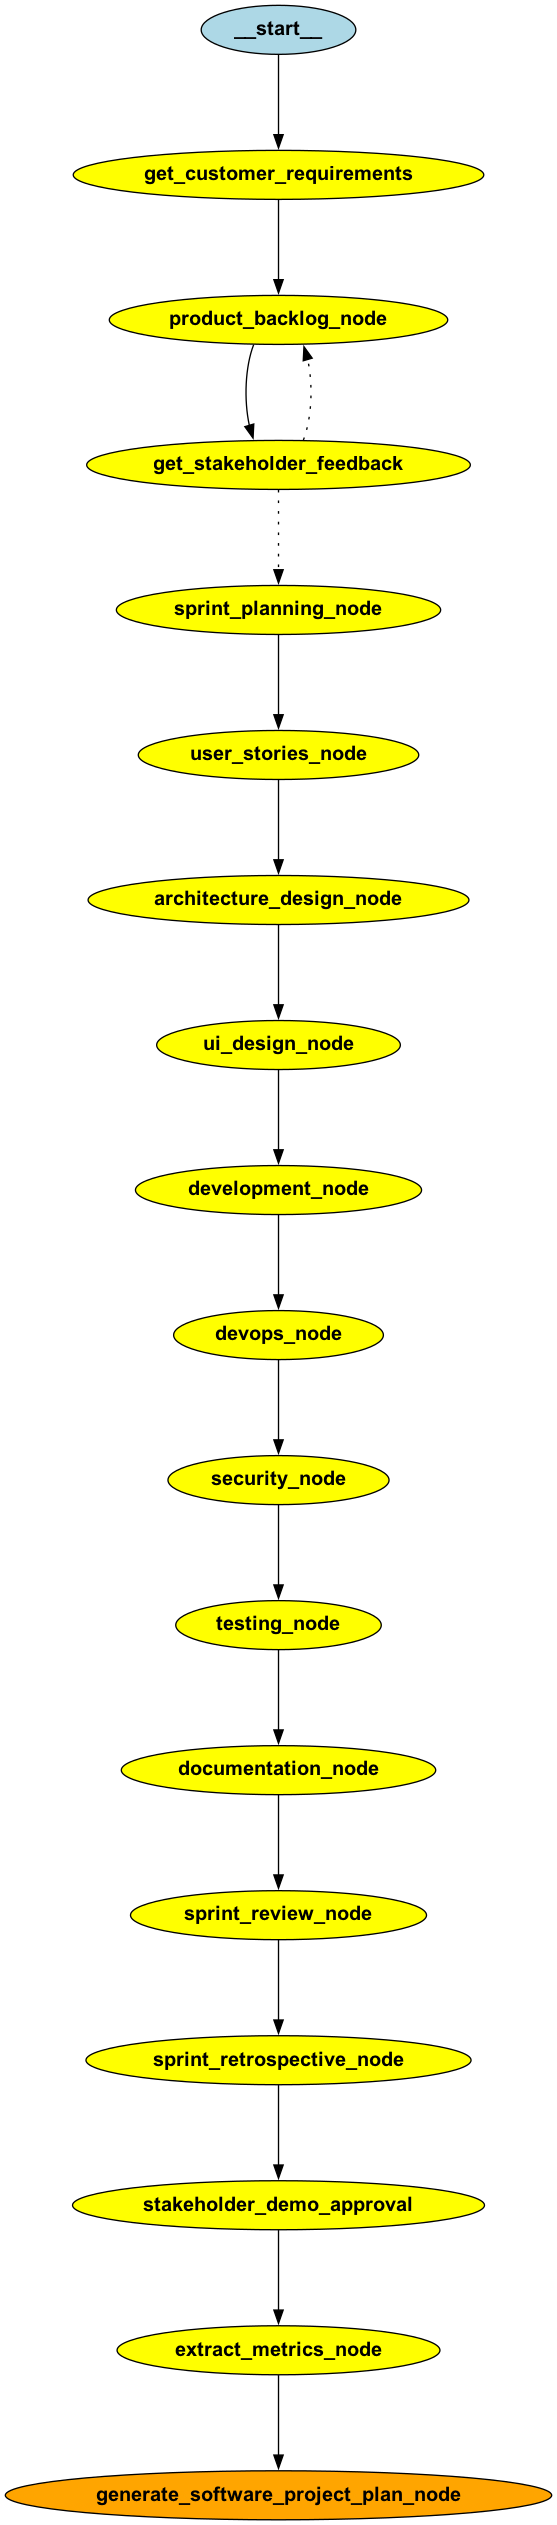

In [ ]:
from IPython.display import Image
Image(graph.get_graph().draw_png())